# <font size="6">Libraries</font>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
from tqdm import tqdm

parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from glob import glob
import os, sys

from src import utils

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

parent_dir = os.path.abspath('..')

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

log = utils.get_logger(__name__)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df = pd.read_parquet('~/ptls-experiments/scenario_alpha_battle/data/train_transactions_contest.parquet', columns=['app_id', 'amnt', 'mcc', 'hour_diff', 'transaction_number'])

In [4]:
%time
df['time'] = df[['app_id', 'hour_diff']].groupby('app_id').cumsum() + 1
df['amnt_bins'] = pd.qcut(df['amnt'], q=[0, .3, .4, .5, 1], labels=False)
df['amnt_mcc_bins'] = (df['mcc'] - 1) * 4 + df['amnt_bins'] + 1 ## Start types from 1 to avoid special 0
print(df['amnt_mcc_bins'].nunique())

CPU times: user 1 µs, sys: 2 µs, total: 3 µs
Wall time: 6.91 µs
432


In [5]:
MIN_NUMBER_OF_TRANSACTIONS = 100
VALIDATION_TRANSACTIONS = 50
VALIDATION_NUM_HOURS = 24 * 30

In [6]:
%%time
df['transaction_max'] = df.groupby('app_id').transaction_number.transform('max')

CPU times: user 4.36 s, sys: 2.71 s, total: 7.07 s
Wall time: 7.07 s


In [7]:
%%time
print(df.shape, df.app_id.nunique())
df = df[df.transaction_max >= MIN_NUMBER_OF_TRANSACTIONS]
print(df.shape, df.app_id.nunique())

(270450065, 9) 963811
(255394648, 9) 634036
CPU times: user 13.5 s, sys: 15.5 s, total: 29 s
Wall time: 28.5 s


In [8]:
%%time
df['reversed_transaction'] = df['transaction_max'] - df['transaction_number']

CPU times: user 446 ms, sys: 559 ms, total: 1 s
Wall time: 857 ms


In [9]:
%%time
train_df = df[df['reversed_transaction'] >= VALIDATION_TRANSACTIONS]
valid_df = df[df['reversed_transaction'] < VALIDATION_TRANSACTIONS]
print(train_df.shape, valid_df.shape)

(223692848, 10) (31701800, 10)
CPU times: user 10 s, sys: 9.85 s, total: 19.9 s
Wall time: 19.8 s


In [10]:
%%time
valid_df['hour_summed'] = valid_df.groupby('app_id')['hour_diff'].cumsum()
hour_summed_max = valid_df.groupby('app_id').hour_summed.max()

<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 1.02 s, sys: 630 ms, total: 1.65 s
Wall time: 1.65 s


In [11]:
(hour_summed_max >= VALIDATION_NUM_HOURS).sum(), (hour_summed_max < VALIDATION_NUM_HOURS).sum()

(430309, 203727)

In [12]:
%%time
app_ids = hour_summed_max[hour_summed_max >= VALIDATION_NUM_HOURS].index

train_df = train_df[train_df.app_id.isin(app_ids)]
valid_df = valid_df[valid_df.app_id.isin(app_ids)]
valid_df = valid_df[valid_df.hour_summed <= VALIDATION_NUM_HOURS]
print(train_df.shape, valid_df.shape)

(95046149, 10) (11183197, 11)
CPU times: user 5.51 s, sys: 10.3 s, total: 15.8 s
Wall time: 15.8 s


<AxesSubplot:>

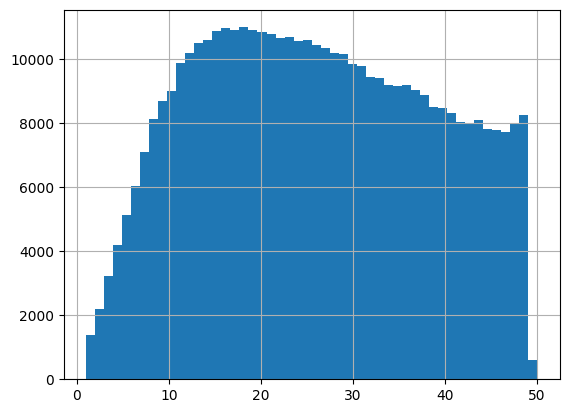

In [13]:
valid_df.groupby('app_id').size().hist(bins=50)

In [14]:
valid_df['transaction_min'] = valid_df.groupby('app_id')['transaction_number'].transform('min')

In [15]:
valid_df[valid_df.transaction_number == valid_df.transaction_min].hour_diff.describe()

count    429711.000000
mean         33.739544
std          67.746008
min           0.000000
25%           1.000000
50%          12.000000
75%          31.000000
max         720.000000
Name: hour_diff, dtype: float64

In [16]:
valid_df.hour_diff.describe()

count    1.118320e+07
mean     2.460099e+01
std      4.700374e+01
min      0.000000e+00
25%      1.000000e+00
50%      8.000000e+00
75%      2.500000e+01
max      7.200000e+02
Name: hour_diff, dtype: float64

In [17]:
train_df.hour_diff.describe()

count    9.504615e+07
mean     2.735514e+01
std      6.734940e+01
min     -1.000000e+00
25%      1.000000e+00
50%      7.000000e+00
75%      2.500000e+01
max      6.932000e+03
Name: hour_diff, dtype: float64

In [18]:
train_df.head()

,app_id,amnt,mcc,hour_diff,transaction_number,time,amnt_bins,amnt_mcc_bins,transaction_max,reversed_transaction
0,0,0.465425,2,-1,1,0,3,8,181,180
1,0,0.000000,2,0,2,0,0,5,181,179
2,0,0.521152,2,0,3,0,3,8,181,178
3,0,0.356078,10,52,4,52,3,40,181,177
4,0,0.000000,2,280,5,332,0,5,181,176


In [19]:
def aggregate(df):
    aggregated =  df[['app_id', 'amnt_mcc_bins', 'time']].groupby('app_id').agg(lambda x: list(x)).reset_index()
    aggregated['trx_count'] = aggregated['time'].apply(len)
    return aggregated

In [20]:
%%time
train = aggregate(train_df)
valid = aggregate(valid_df)

CPU times: user 50.8 s, sys: 4.68 s, total: 55.5 s
Wall time: 55.5 s


In [21]:
%%time
train.to_parquet('data/train.parquet', index=False)
valid.to_parquet('data/valid.parquet', index=False)

CPU times: user 11.3 s, sys: 2.19 s, total: 13.5 s
Wall time: 13.4 s
